In [52]:
rm(list = ls())
setwd('./')

library(Scissor)
library(tidydr)
library(Seurat)
library(dplyr)
library(ggplot2)
library(cols4all)
library(CellChat)
library(dplyr)

In [53]:
load('./data/raw/GSE132465_UMI_count_matrix.Rdata')

anno <- read.table('./data/raw/GSE132465_GEO_processed_CRC_10X_cell_annotation.txt',
                    header = TRUE, sep = "\t")

anno$Index <- gsub('-','.',anno$Index)

sc_dataset <- Seurat_preprocessing(molecules, verbose = T)

load('./data/processed/str_scissor_cells.Rdata')
Scissor_select <- anno[,c('Cell_type','Cell_subtype')]
rownames(Scissor_select) <- anno$Index

Scissor_select[infos1$Scissor_pos,c('Cell_type','Cell_subtype')] <- 'Poor prognosis related cells'
Scissor_select[infos1$Scissor_neg,c('Cell_type','Cell_subtype')] <- 'Good prognosis related cells'
Scissor_select[Scissor_select$Cell_type=='Stromal cells',c('Cell_type','Cell_subtype')] <- 'Background cells'

all(rownames(Scissor_select) == colnames(sc_dataset))
sc_dataset$anno <- Scissor_select$Cell_subtype

Centering and scaling data matrix

PC_ 1 
Positive:  CALD1, IGFBP7, COL6A2, SPARC, COL1A2, C1R, C1S, COL3A1, COL6A1, COL1A1 
	   NNMT, LUM, DCN, FSTL1, THY1, MMP2, RARRES2, PCOLCE, SERPING1, FBLN1 
	   PRKCDBP, EFEMP2, SERPINF1, AEBP1, MYL9, MEG3, IGFBP4, PTRF, COL6A3, CTSK 
Negative:  CD69, LTB, CCL5, TRBC1, AREG, KLRB1, GZMA, EPCAM, TSPAN8, CLDN3 
	   HMGA1, NKG7, CD24, DUSP2, CD27, ALOX5AP, ELF3, GPX2, CEACAM5, CLDN4 
	   LGALS4, CLDN7, KRT18, GZMB, TIGIT, CDX1, KRT19, SFN, KRT8, ICOS 
PC_ 2 
Positive:  EPCAM, KRT18, KRT8, CEACAM5, CLDN3, KRT19, CLDN4, TSPAN8, LGALS4, CLDN7 
	   CD24, ELF3, FXYD3, SFN, AGR2, GPRC5A, S100A14, TMEM54, S100P, TFF3 
	   PRSS3, GPX2, S100A16, MAL2, PHLDA2, CEACAM6, PLPP2, PERP, SMIM22, FHL2 
Negative:  VIM, CD69, CD74, GPR183, S100A4, IGKC, HLA-DPB1, RGS2, ALOX5AP, CCL5 
	   HLA-DPA1, RGCC, ITGB2, LTB, IL7R, HLA-DQA1, TRBC1, IGHA1, HLA-DRB1, LGALS1 
	   CCL4, HLA-DQB1, HLA-DRA, KLRB1, HLA-DRB5, NKG7, TYMP, CD83, ITM2A, GZMA 
PC_ 3 
Positive:  FCER1G, TYR

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 63689
Number of edges: 1906577

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9291
Number of communities: 23
Elapsed time: 22 seconds


23:55:28 UMAP embedding parameters a = 0.9922 b = 1.112

23:55:28 Read 63689 rows and found 10 numeric columns

23:55:28 Using Annoy for neighbor search, n_neighbors = 30

23:55:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:55:35 Writing NN index file to temp file /tmp/RtmputDoXz/file2b1e4faf19ac2

23:55:35 Searching Annoy index using 1 thread, search_k = 3000

23:55:59 Annoy recall = 100%

23:55:59 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

23:56:02 Initializing from normalized Laplacian + noise (using RSpectra)

23:56:20 Commencing optimization for 200 epochs, with 2679618 positive edges

23:56:53 Optimization finished



[1] TRUE

In [54]:
ob <- GetAssayData(object = sc_dataset, slot = 'data')
mt <- sc_dataset@meta.data

cellchat <- createCellChat(object = ob,
                           meta = mt,
                           group.by = 'anno')
cellchat@DB <- CellChatDB.human
cellchat <- subsetData(cellchat) ##save time and memory
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)
cellchat <- computeCommunProb(cellchat)
cellchat <- filterCommunication(cellchat, min.cells = 10)

cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

groupSize <- table(cellchat@idents) %>% as.numeric()

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Background cells, CD19+CD20+ B, CD4+ T cells, CD8+ T cells, cDC, CMS1, CMS2, CMS3, CMS4, gamma delta T cells, Goblet cells, Good prognosis related cells, IgA+ Plasma, IgG+ Plasma, Intermediate, Mast cells, Mature Enterocytes type 1, Mature Enterocytes type 2, NK cells, Poor prognosis related cells, Pro-inflammatory, Proliferating, Regulatory T cells, SPP1+, Stem-like/TA, T follicular helper cells, T helper 17 cells, Unknown 


The number of highly variable ligand-receptor pairs used for signaling inference is 981 
triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2025-01-12 23:57:06.818244]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2025-01-13 00:10:27.307313]"


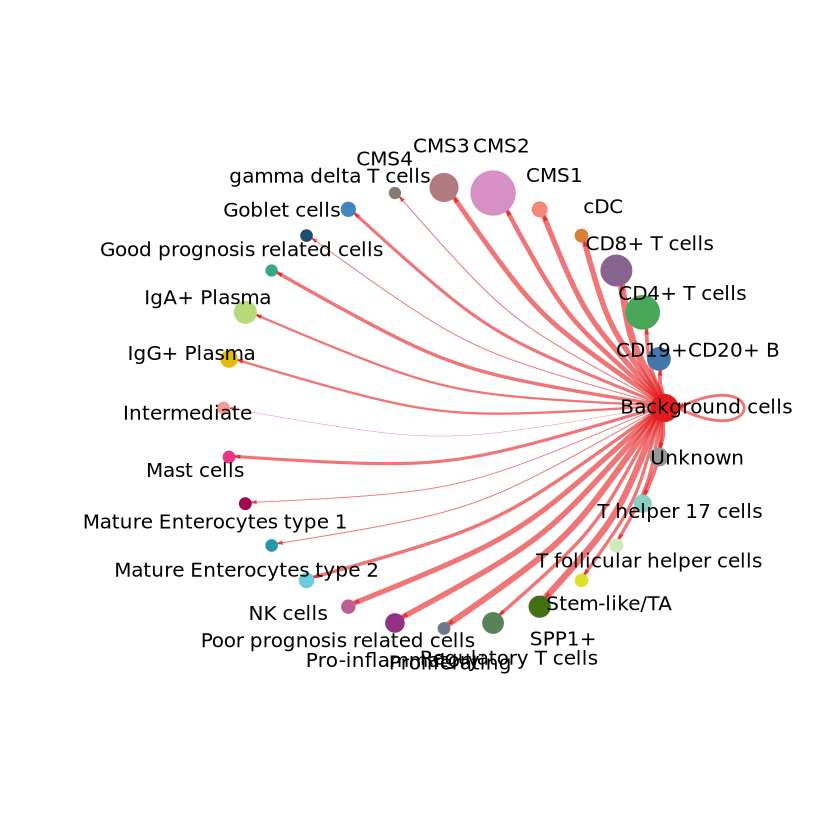

In [55]:
groupSize <- table(cellchat@idents) %>% as.numeric()
i = 1
mat <- matrix(0, 
              nrow = nrow(cellchat@net$weight),
              ncol = ncol(cellchat@net$weight),
              dimnames = dimnames(cellchat@net$weight))
mat[i, ] <- cellchat@net$weight[i, ]
print(netVisual_circle(mat, 
                vertex.weight = groupSize,
                weight.scale = T,
                edge.weight.max = max(cellchat@net$weight),
                title.name = rownames(mat)[i]))

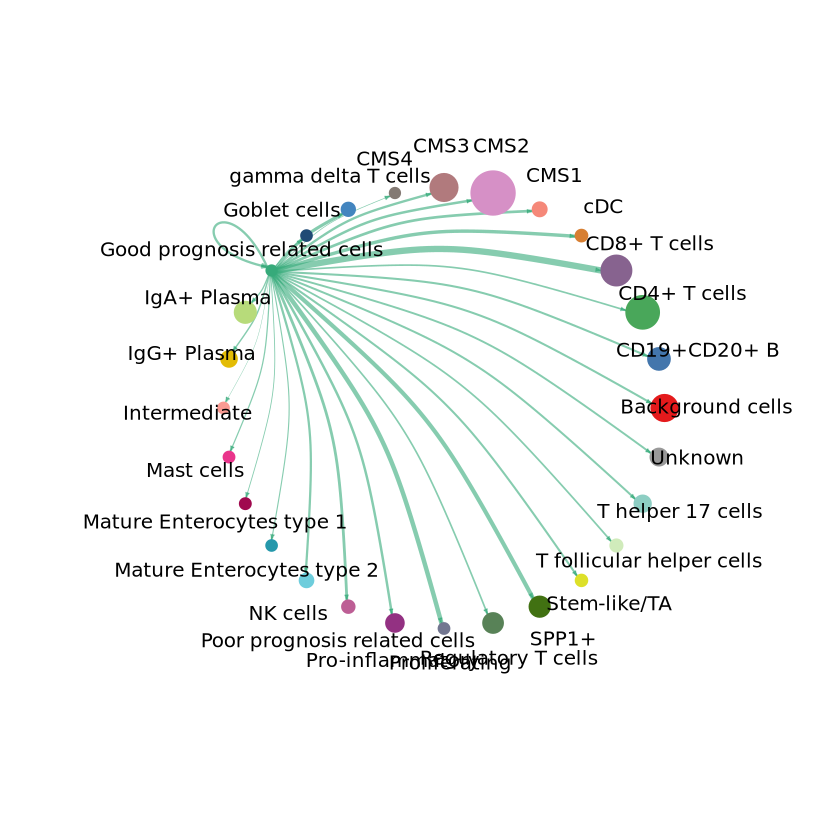

In [56]:
i = 12
mat <- matrix(0, 
              nrow = nrow(cellchat@net$weight),
              ncol = ncol(cellchat@net$weight),
              dimnames = dimnames(cellchat@net$weight))
mat[i, ] <- cellchat@net$weight[i, ]
print(netVisual_circle(mat, 
                  vertex.weight = groupSize,
                  weight.scale = T,
                  edge.weight.max = max(cellchat@net$weight),
                  title.name = rownames(mat)[i]))

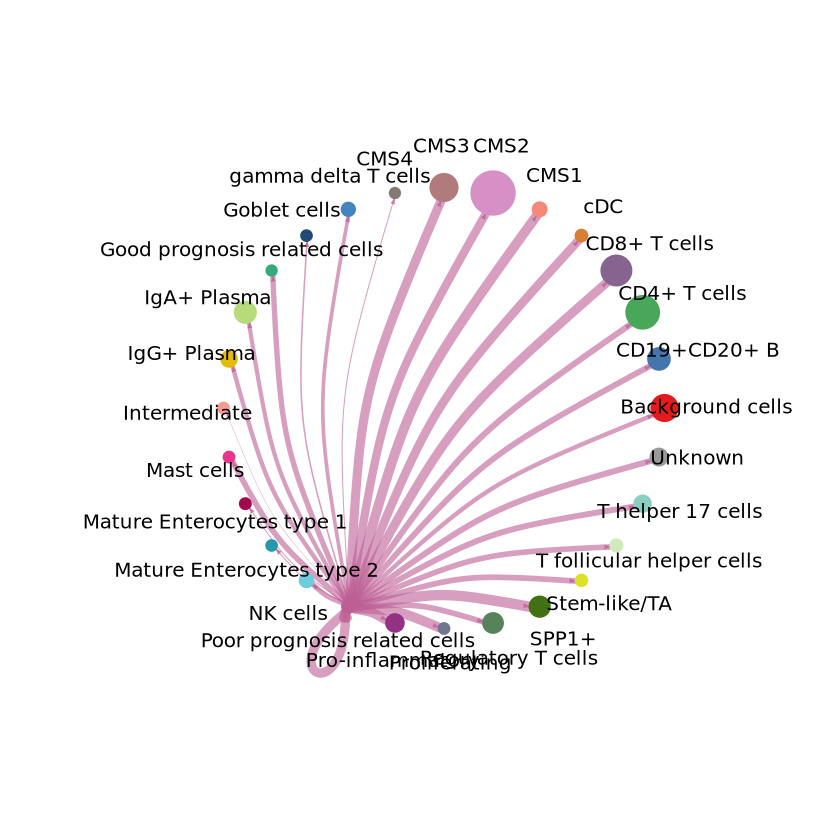

In [57]:
i = 20
mat <- matrix(0, 
              nrow = nrow(cellchat@net$weight),
              ncol = ncol(cellchat@net$weight),
              dimnames = dimnames(cellchat@net$weight))
mat[i, ] <- cellchat@net$weight[i, ]
print(netVisual_circle(mat, 
                  vertex.weight = groupSize,
                  weight.scale = T,
                  edge.weight.max = max(cellchat@net$weight),
                  title.name = rownames(mat)[i]))

.
            Background cells                 CD19+CD20+ B 
                        5189                         3733 
                CD4+ T cells                 CD8+ T cells 
                        7305                         6404 
                         cDC                         CMS1 
                         482                         1201 
                        CMS2                         CMS3 
                       10771                         5486 
                        CMS4          gamma delta T cells 
                          11                          996 
                Goblet cells Good prognosis related cells 
                         139                           25 
                 IgA+ Plasma                  IgG+ Plasma 
                        3546                         1755 
                Intermediate                   Mast cells 
                         181                          187 
   Mature Enterocytes type 1    Mature Enterocytes typ

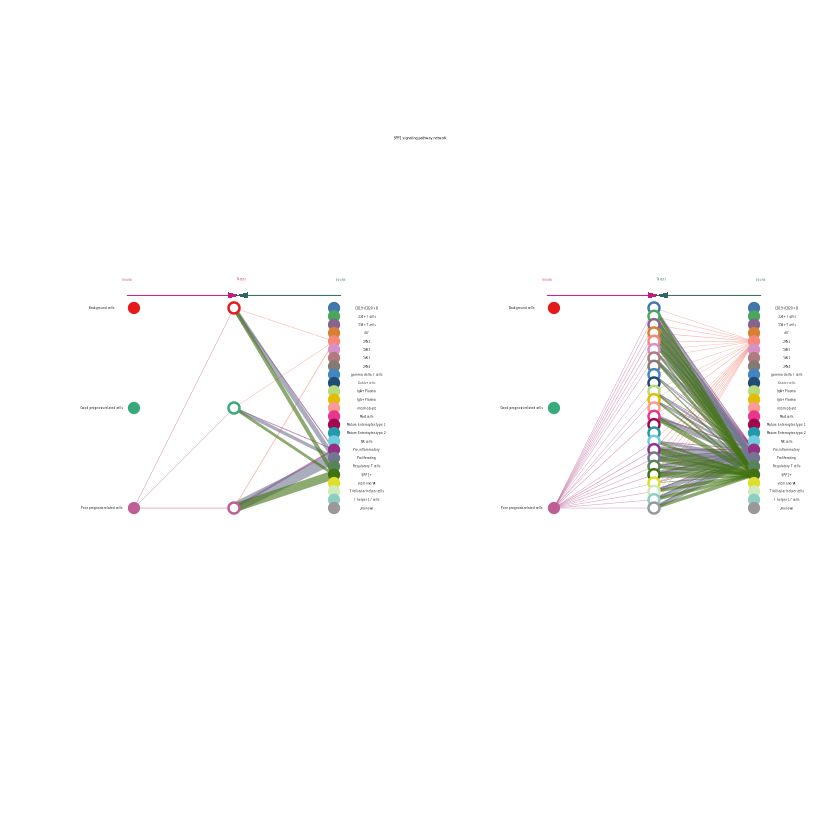

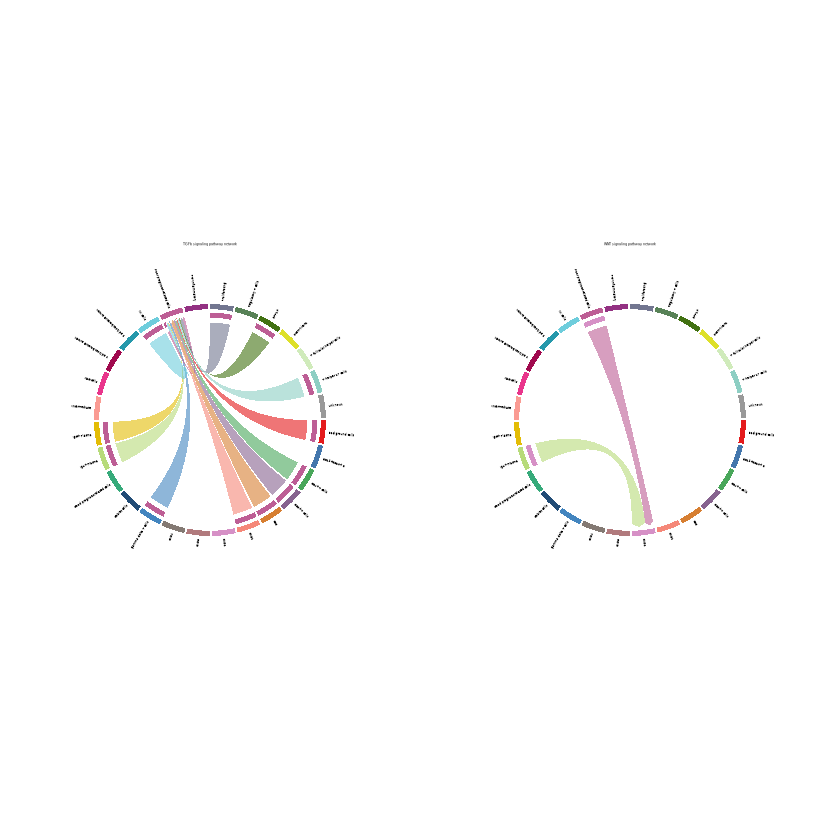

In [58]:
cellchat@meta$anno %>% table() 

vertex.receiver <- c(which(names(table(cellchat@meta$ann)) == "Background cells"),
                     which(names(table(cellchat@meta$ann)) == "Good prognosis related cells"),
                     which(names(table(cellchat@meta$ann)) == "Poor prognosis related cells"))

print(netVisual_aggregate(cellchat, 
                signaling = 'SPP1', 
                thresh = 0.05,
                pt.title = 2,
                vertex.receiver = vertex.receiver,
                layout = 'hierarchy'))

print(netVisual_aggregate(cellchat, 
                signaling = 'TGFb', 
                thresh = 0.05,
                pt.title = 2,
                vertex.receiver = vertex.receiver,
                layout = 'chord'))

print(netVisual_aggregate(cellchat, 
                signaling = 'WNT', 
                thresh = 0.05,
                pt.title = 2,
                vertex.receiver = vertex.receiver,
                layout = 'chord'))

NULL


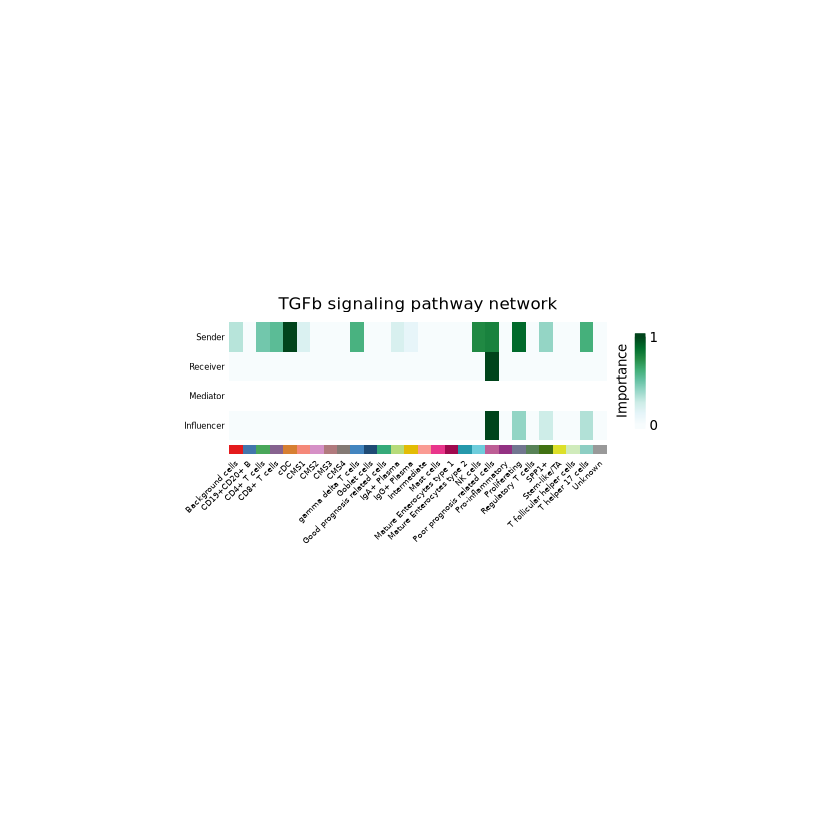

In [61]:
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

print(netAnalysis_signalingRole_network(cellchat, signaling = 'TGFb', 
                                  width = 8, height = 2.5, font.size = 5))

NULL


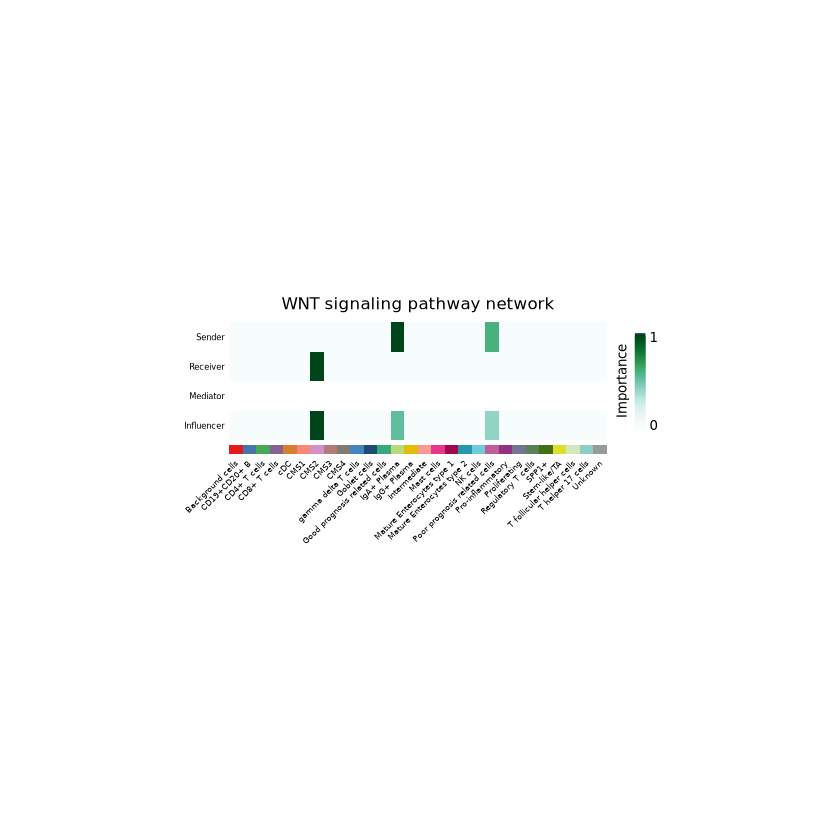

In [62]:
print(netAnalysis_signalingRole_network(cellchat, signaling = 'WNT', 
                                  width = 8, height = 2.5, font.size = 5))


NULL


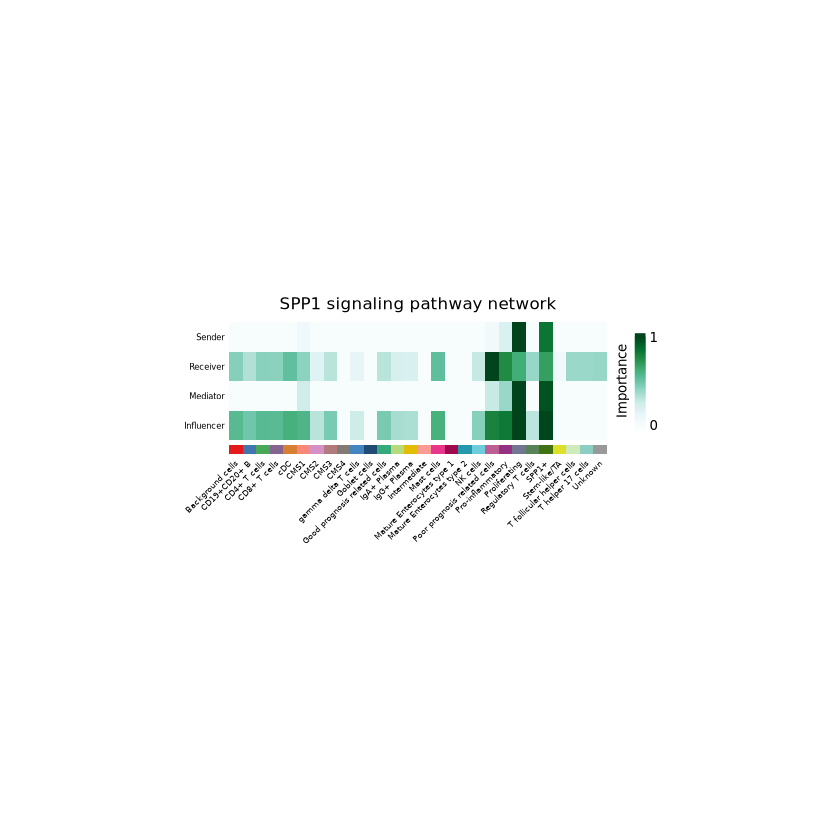

In [63]:
print(netAnalysis_signalingRole_network(cellchat, signaling = 'SPP1', 
                                  width = 8, height = 2.5, font.size = 5))

In [51]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 12 (bookworm)

Matrix products: default
BLAS/LAPACK: ./anaconda3/envs/scCRC/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] CellChat_2.1.2      Biobase_2.60.0      BiocGenerics_0.46.0
 [4] igraph_1.5.1        cols4all_0.6        ggplot2_3.4.3      
 [7] dplyr_1.1.3         tidydr_0.0.5        Scissor_2.0.0      
[10] Matrix_1.6-1.1      Seura